In [1]:
!git clone -b unet-gan https://github.com/hoangbros03/GAN-implement.git
!pip install torch-fidelity

Cloning into 'GAN-implement'...
remote: Enumerating objects: 20641, done.
remote: Counting objects: 100% (383/383), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 20641 (delta 196), reused 377 (delta 194), pack-reused 20258
Receiving objects: 100% (20641/20641), 549.07 MiB | 40.00 MiB/s, done.
Resolving deltas: 100% (197/197), done.


In [2]:
import os
os.chdir('GAN-implement')
!pip install -e .
import sys
sys.path.append('src')
sys.path.append('evaluate')
sys.path.append('src/pure_gan')
sys.path.append('src/cnn_gan')

Obtaining file:///kaggle/working/GAN-implement
  Preparing metadata (setup.py) ... done
  Running setup.py develop for GAN-implementation


In [3]:
from evaluate import convert_dataloader_to_sample, kernel_inception_distance, frechet_inception_distance, convert_rgb, unnormalize
from src.pure_gan.mnist_dataloader import check_and_process_dataloader
from src.cnn_gan.train import Trainer
dataloader = check_and_process_dataloader("mnist", (1, 28, 28), 32)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The path 'mnist' exists.


In [4]:
import argparse

args = argparse.Namespace(
    epochs=5,
    image_size=28,
    batch_size=32,
    noise_size=100,
    learning_rate=0.0001,
    proportion=3,
    discriminator_type="mnist",
    generator_type="mnist",
    device="cuda",
    key = None,
    output_dir="models",
    save_model=True,
    num_workers=2,
    save_frequency=3,
    channel=1
)

In [5]:
"""Train file of enhanced GAN"""
import argparse

import torch
from torch import nn
from torch import optim
import torchvision.utils as vutils
import wandb
from tqdm import tqdm
from pure_gan.utils import check_and_create_dir
from pure_gan.mnist_dataloader import check_and_process_dataloader
from cnn_gan.layers import (
    Discriminator,
    Generator,
    Generator_Ablation,
    Discriminator_Ablation,
    GeneratorMNIST,
    DiscriminatorMNIST,
)
from cnn_gan.reader import Reader


class Trainer:
    """Trainer class"""

    def __init__(self, args):
        """Constructor of class Trainer

        Args:
            args (argparse): arguments specified when running file

        Raises:
            ValueError: generator must have type as defined
            ValueError: discriminator must have type as defined
        """
        # args.device, args.generator_type, args.discriminator_type, args.learning_rate
        self.args = args
        self.device = args.device
        generator = args.generator_type
        discriminator = args.discriminator_type
        lr = args.learning_rate
        channel = args.channel

        self.criterion = nn.BCELoss()
        self.channel = channel
        self.img_size = args.image_size
        args.image_size = int(args.image_size)
        if generator == "normal":
            self.netG = Generator(img_size=args.image_size, channel=channel).to(
                self.device
            )
        elif generator == "mnist":
            self.netG = GeneratorMNIST(img_size=args.image_size, channel=channel).to(
                self.device
            )
        elif generator == "ablation":
            self.netG = Generator_Ablation().to(self.device)
        else:
            raise ValueError("generator must be either normal or ablation")

        if discriminator == "normal":
            self.netD = Discriminator(img_size=args.image_size, channel=channel).to(
                self.device
            )
        elif discriminator == "mnist":
            self.netD = DiscriminatorMNIST(
                img_size=args.image_size, channel=channel
            ).to(self.device)
        elif discriminator == "ablation":
            self.netD = Discriminator_Ablation().to(self.device)
        else:
            raise ValueError("discriminator must be either normal or ablation")

        # Establish convention for real and fake labels during training
        self.real_label = 1.0
        self.fake_label = 0.0

        # Setup Adam optimizers for both G and D
        self.optimizerD = optim.Adam(self.netD.parameters(), lr=lr, betas=(0.5, 0.999))
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=lr, betas=(0.5, 0.999))

        self.pred = []
        self.img_list = []
        self.G_losses = []
        self.D_losses = []

    def train_loop(self, dataloader):
        """Trainning loop

        Args:
            dataloader (_type_): The dataloader
        """
        # Set up variables
        num_epochs = self.args.epochs
        noise_size = self.args.noise_size
        b_size = self.args.batch_size
        D_G_train_proportion = self.args.proportion

        fixed_noise = torch.randn(b_size, noise_size, 1, 1, device=self.device)

        # Lists to keep track of progress
        iters = 0

        # print("Starting Training Loop...")
        # For each epochs

        for epoch in tqdm(range(num_epochs)):
            # For each batch in the dataloader
            for i, data in enumerate(dataloader, 0):
                if i % D_G_train_proportion == 0:
                    ############################
                    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                    ###########################
                    ## Train with all-real batch
                    # print("\n=============DISCRIMINATOR TRAINING=============\n")
                    # print("Training true batch...")
                    self.netD.zero_grad()
                    # Format batch
                    real_cpu = data[0].to(self.device)
                    b_size = real_cpu.size(0)
                    label = torch.full(
                        (b_size,),
                        self.real_label,
                        dtype=torch.float,
                        device=self.device,
                    )
                    real_cpu.view(b_size, self.img_size, self.img_size, self.channel)
                    # print("Forwarding batch...")
                    # Forward pass real batch through D
                    output = self.netD(real_cpu).squeeze()
                    # Calculate loss on all-real batch
                    # print("Calculating loss...")
                    # print(f"Shape: Output: {output.shape}, label: {label.shape}")
                    errD_real = self.criterion(output, label)
                    # Calculate gradients for D in backward pass
                    errD_real.backward()
                    # D_x = output.mean().item()

                    # print("\nTraining fake batch...")
                    ## Train with all-fake batch
                    # Generate batch of latent vectors
                    noise = torch.randn(b_size, noise_size, 1, 1, device=self.device)
                    # Generate fake image batch with G
                    # print("Generating...")
                    fake = self.netG(noise)
                    # print(f"Fake shape: {fake.shape}")
                    label.fill_(self.fake_label)
                    # Classify all fake batch with D
                    # print("Classfying with D...")
                    output = self.netD(fake.detach()).view(-1)
                    # Calculate D's loss on the all-fake batch
                    # print("Calculating loss...")
                    # print(f"Shape: Output: {output.shape}, label: {label.shape}")
                    errD_fake = self.criterion(output, label)
                    # Calculate the gradients for this batch,
                    # accumulated (summed) with previous gradients
                    # print("Backward pass...")
                    errD_fake.backward()
                    # D_G_z1 = output.mean().item()
                    # Compute error of D as sum over the fake and the real batches
                    errD = errD_real + errD_fake
                    # Update D
                    self.optimizerD.step()
                    # print("Done training discriminator...")

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                # print("\n=============GENERATOR TRAINING=============\n")
                noise = torch.randn(b_size, noise_size, 1, 1, device=self.device)
                # Generate fake image batch with G
                # print("Generating...")
                fake = self.netG(noise)
                self.netG.zero_grad()
                label.fill_(self.real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                # print("Generating...")
                output = self.netD(fake).view(-1)
                # Calculate G's loss based on this output
                # print("Calculating G's loss...")
                errG = self.criterion(output, label)
                # Calculate gradients for G
                # print("Backward pass...")
                errG.backward()
                # D_G_z2 = output.mean().item()
                # Update G
                self.optimizerG.step()
                # print("Done training generator...")

                # Save Losses for plotting later
                self.G_losses.append(errG.item())
                self.D_losses.append(errD.item())

                if bool(self.args.key):
                    wandb.log(
                        {
                            "g_loss": errG.item(),
                            "d_loss": errD.item(),
                        }
                    )

                # print("Generating on fixed noise...")
                # Check how the generator is doing by saving G's output on fixed_noise
                # Reduce time append to save the ram usage
                if (iters % 2000 == 0):
                    with torch.no_grad():
                        fake = self.netG(fixed_noise).detach().cpu()
                    self.img_list.append(
                        vutils.make_grid(fake, padding=2, normalize=True)
                    )
                    self.pred.append(
                        self.netG(
                            torch.randn(128, noise_size, 1, 1, device=self.device)
                        )
                        .detach()
                        .cpu()
                    )

                iters += 1

            if self.args.save_model:
                if (
                    epoch + 1
                ) % self.args.save_frequency == 0 or epoch == num_epochs - 1:
                    check_and_create_dir(self.args.output_dir)
                    torch.save(
                        self.netG.state_dict(),
                        f"{self.args.output_dir}/{str(self.args.generator_type)}\
                            _{str(self.args.discriminator_type)}_{str(epoch+1)}.pth",
                    )

In [ ]:
trainer = Trainer(args)
trainer.train_loop(dataloader)

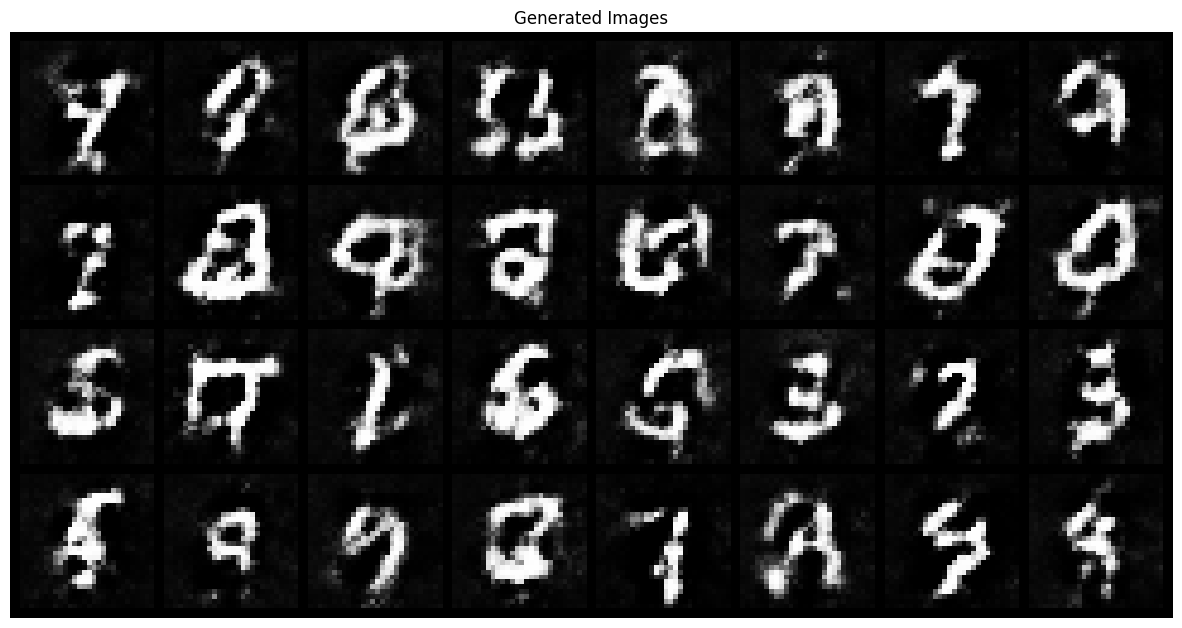

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Plot the fake images from the last epoch
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(trainer.img_list[1],(1,2,0)))
plt.savefig('gan-1')
plt.show()

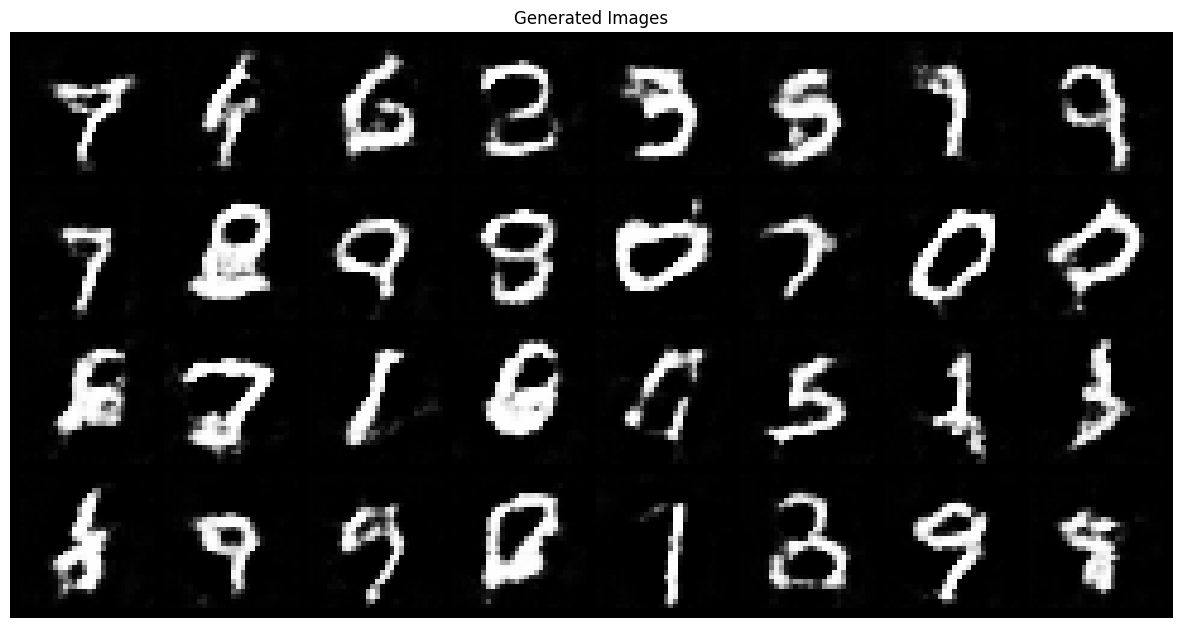

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Plot the fake images from the last epoch
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(trainer.img_list[2],(1,2,0)))
plt.savefig('gan-1')
plt.show()

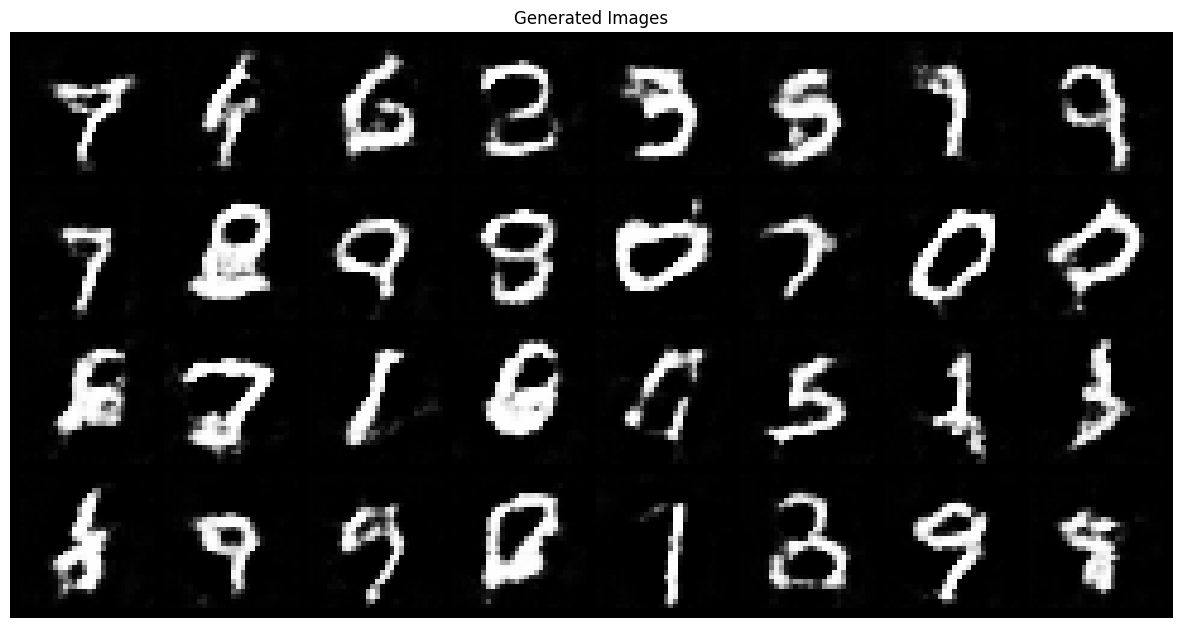

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Plot the fake images from the last epoch
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(trainer.img_list[2],(1,2,0)))
plt.savefig('gan-1')
plt.show()

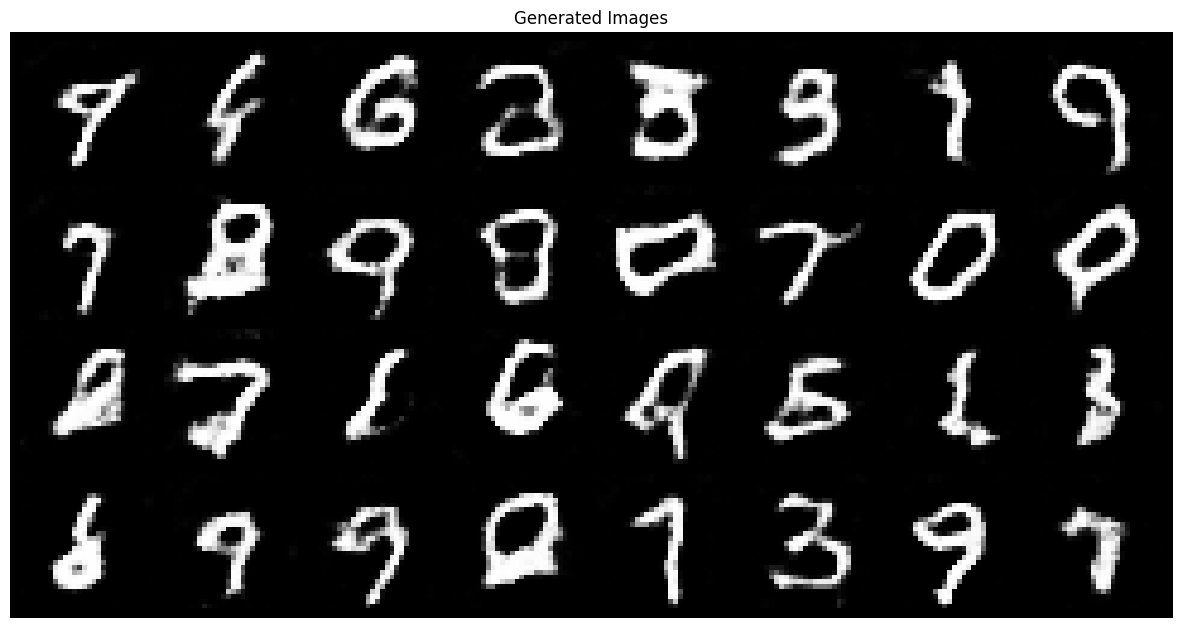

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Plot the fake images from the last epoch
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(trainer.img_list[3],(1,2,0)))
plt.savefig('gan-1')
plt.show()

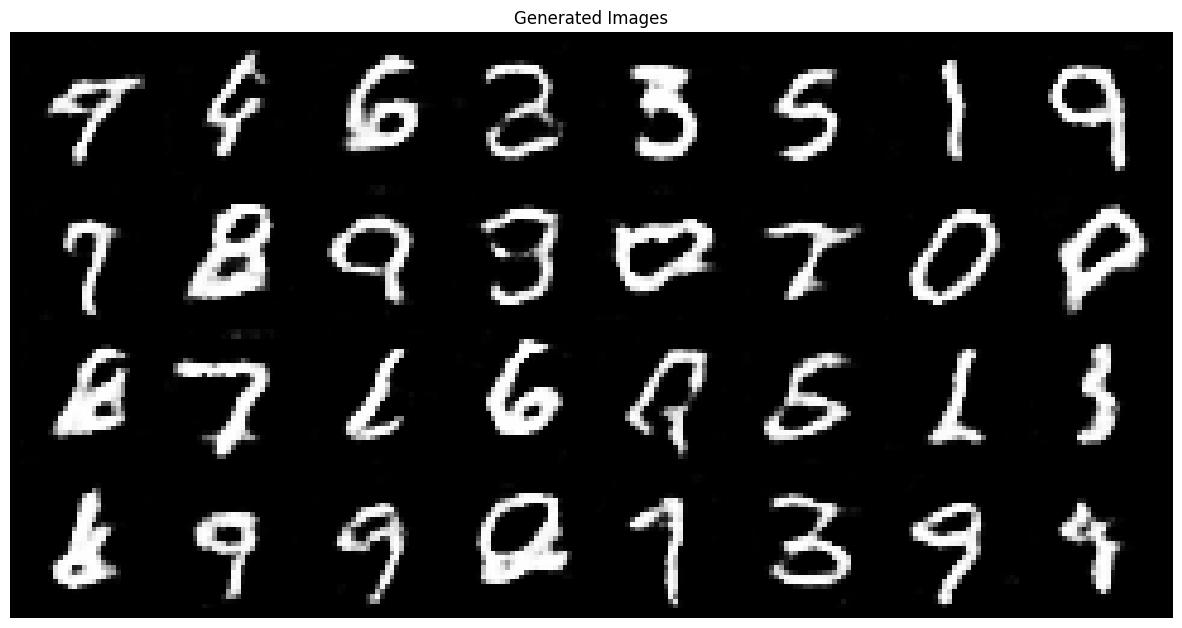

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Plot the fake images from the last epoch
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(trainer.img_list[4],(1,2,0)))
plt.savefig('gan-1')
plt.show()

In [46]:
gt = convert_dataloader_to_sample(dataloader)
for i in range(len(trainer.pred)):
    print(f"Iteration {i}")
    print(frechet_inception_distance(convert_rgb(unnormalize(trainer.pred[i])), convert_rgb(unnormalize(gt))))
    print(kernel_inception_distance(convert_rgb(unnormalize(trainer.pred[i])), convert_rgb(unnormalize(gt))))

Iteration 0
tensor(24.3796)


/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


(tensor(0.6944), tensor(0.0091))
Iteration 1
tensor(2.0513)
(tensor(0.1909), tensor(0.0068))
Iteration 2
tensor(0.1448)
(tensor(0.0520), tensor(0.0039))
Iteration 3
tensor(0.0479)
(tensor(0.0355), tensor(0.0049))
Iteration 4
tensor(0.0290)
(tensor(0.0177), tensor(0.0033))


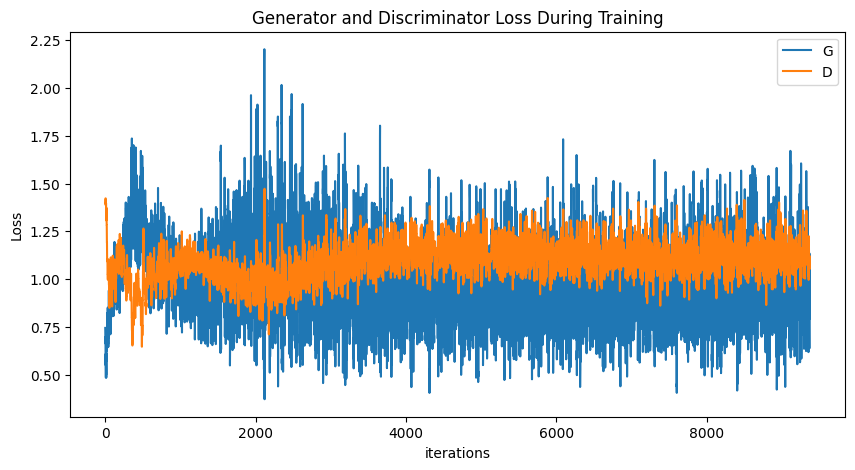

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainer.G_losses,label="G")
plt.plot(trainer.D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()